In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<b> Wczytanie danych i pre-processing</b>

In [2]:
with open("spam_ham.txt", "r") as f:
    data = f.readlines()

In [3]:
#Split i zamiana labelek na 0/1
spl = [elem.split("\t") for elem in data]
df = pd.DataFrame(spl, columns=["Category", "Text"])
df["Category"] = df["Category"].replace({"spam": 0, "ham": 1})
df.head()
print(df)
print("Category breakdown before dataset augmentation:")
print(df.groupby('Category').size())


      Category                                               Text
0            1  Go until jurong point, crazy.. Available only ...
1            1                    Ok lar... Joking wif u oni...\n
2            0  Free entry in 2 a wkly comp to win FA Cup fina...
3            1  U dun say so early hor... U c already then say...
4            1  Nah I don't think he goes to usf, he lives aro...
...        ...                                                ...
5569         0  This is the 2nd time we have tried 2 contact u...
5570         1             Will ü b going to esplanade fr home?\n
5571         1  Pity, * was in mood for that. So...any other s...
5572         1  The guy did some bitching but I acted like i'd...
5573         1                       Rofl. Its true to its name\n

[5574 rows x 2 columns]
Category breakdown before dataset augmentation:
Category
0     747
1    4827
dtype: int64


<b> Augumentacja zbioru danych do symetrycznej postaci<br/>
z wykorzystaniem NLTK, losowania tokenów i stemmingu</b>

In [4]:
# Fun
def data_augmentation(data: list, how_many: int) -> list:
    tokenized = [word_tokenize(text) for text in data]
    dummy_data = []
    ps = PorterStemmer()
    for _ in range(how_many):
        mess = random.choice(tokenized)
        mess = " ".join([ps.stem(w) for w in mess])
        dummy_data.append(mess)
    augmented = data + dummy_data
    return augmented

In [5]:
ham, spam = len(df[df["Category"] == 1]), len(df[df["Category"] == 0])
iters = abs(ham - spam)
spams = df[df["Category"] == 0]
hams = df[df["Category"] == 1].reset_index(drop=True)
texts = [text for text in spams["Text"]]
augmented = data_augmentation(texts, iters)
new_df = pd.DataFrame([{"Category": 0, "Text": elem} for elem in augmented])

In [6]:
aug_df = shuffle(pd.concat([new_df, hams])).reset_index(drop=True)
print(aug_df)
print("Category breakdown after dataset augmentation:")
print(aug_df.groupby('Category').size())


      Category                                               Text
0            0  you have won ? 1,000 cash or a ? 2,000 prize !...
1            1                           I said its okay. Sorry\n
2            1               Is fujitsu s series lifebook good?\n
3            0  final chanc ! claim ur £150 worth of discount ...
4            1  Why is that, princess? I bet the brothas are a...
...        ...                                                ...
9649         1                                Then u drive lor.\n
9650         1                      "Are you comingdown later?"\n
9651         1  Let me know if you need anything else. Salad o...
9652         1  Hello! Just got here, st andrews-boy its a lon...
9653         0  3 free tarot text ! find out about your love l...

[9654 rows x 2 columns]
Category breakdown after dataset augmentation:
Category
0    4827
1    4827
dtype: int64


<b>Podział na dane treningowe i testowe
i wektoryzacja z wykorzystaniem TF-IDF</b>

In [7]:
x_train, x_test, y_train, y_test = train_test_split(aug_df["Text"], aug_df["Category"],
                                                    test_size=.2, random_state=1234)

In [8]:
vectorizer = TfidfVectorizer()
vectorizer.fit(aug_df["Text"])

x_tr_arr = vectorizer.transform(x_train).toarray()

x_te_arr = vectorizer.transform(x_test).toarray()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
X_train = torch.from_numpy(x_tr_arr.astype(np.float32))
X_test = torch.from_numpy(x_te_arr.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)
print(y_test)

tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])


<b>Budowa modelu i trening</b></br></br>
Dodatkowo, liczone są metryki na poszczególnych krokach treningu</br>
w celu wizualizacji danych na końcowym etapie

In [10]:
class logModel(nn.Module):
    def __init__(self, n_features):
        super(logModel, self).__init__()
        self.linear = nn.Linear(n_features, 1) #tu: y=wx+b
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

model = logModel(n_features=X_train.shape[1])

num_epochs = 10001
learning_rate = 0.01
losses, train_acc, valid_acc = [], [], []
epochs = []
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):

    y_pred = model(X_train)
    loss = loss_function(y_pred, y_train)

    loss.backward()
    optimizer.step()

    optimizer.zero_grad()


    if (epoch) % 100 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
        losses.append(loss.item())
        epochs.append(epoch)
        with torch.no_grad():
            # Calculate train performance metrics
            y_predicted = model(X_train)
            y_predicted_cls = y_predicted.round()
            acc = y_predicted_cls.eq(y_train).sum() / float(y_train.shape[0])
            train_acc.append(acc.item())
            print(f'epoch: {epoch+1}, accuracy: {acc.item():.4f}')
            # Calculate test performance metrics
            y_predicted = model(X_test)
            y_predicted_cls = y_predicted.round()
            acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
            valid_acc.append(acc.item())
            print(f'epoch: {epoch+1}, accuracy: {acc.item():.4f}')

epoch: 1, loss = 0.6929
epoch: 1, accuracy: 0.5072
epoch: 1, accuracy: 0.5251
epoch: 101, loss = 0.6911
epoch: 101, accuracy: 0.6650
epoch: 101, accuracy: 0.6841
epoch: 201, loss = 0.6892
epoch: 201, accuracy: 0.8211
epoch: 201, accuracy: 0.8229
epoch: 301, loss = 0.6873
epoch: 301, accuracy: 0.8985
epoch: 301, accuracy: 0.8985
epoch: 401, loss = 0.6855
epoch: 401, accuracy: 0.9314
epoch: 401, accuracy: 0.9244
epoch: 501, loss = 0.6837
epoch: 501, accuracy: 0.9404
epoch: 501, accuracy: 0.9347
epoch: 601, loss = 0.6818
epoch: 601, accuracy: 0.9416
epoch: 601, accuracy: 0.9389
epoch: 701, loss = 0.6800
epoch: 701, accuracy: 0.9437
epoch: 701, accuracy: 0.9415
epoch: 801, loss = 0.6782
epoch: 801, accuracy: 0.9467
epoch: 801, accuracy: 0.9430
epoch: 901, loss = 0.6764
epoch: 901, accuracy: 0.9482
epoch: 901, accuracy: 0.9451
epoch: 1001, loss = 0.6746
epoch: 1001, accuracy: 0.9498
epoch: 1001, accuracy: 0.9461
epoch: 1101, loss = 0.6728
epoch: 1101, accuracy: 0.9507
epoch: 1101, accuracy:

Finalna dokładność modelu na wytrenowanym zbiorze testowym:

In [11]:
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'Final accuracy: {acc.item():.4f}')

Final accuracy: 0.9529


<b>Wygenerowanie wykresów podstawowych metryk do ewaluacji modelu</b>

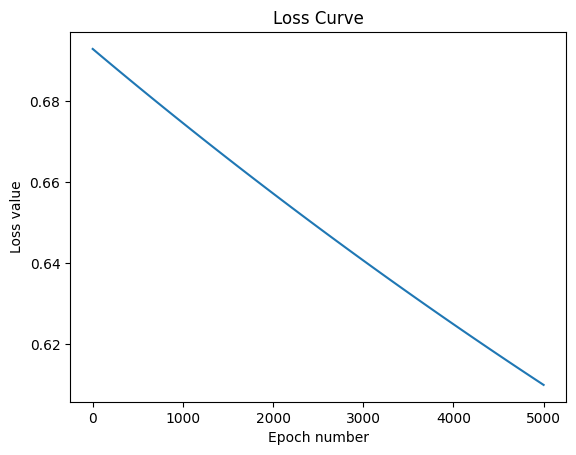

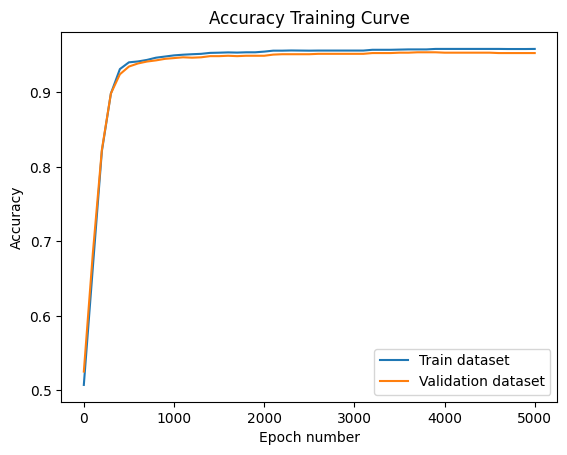

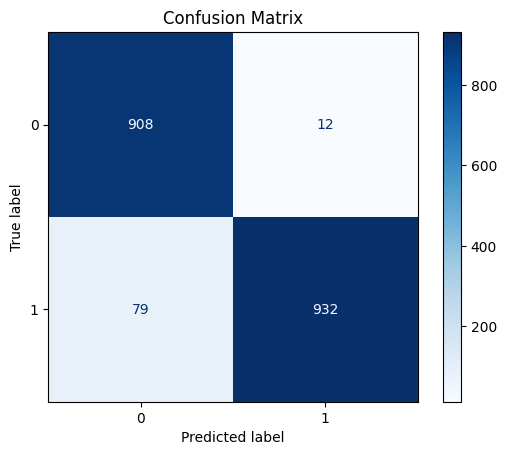

In [14]:
plt.title("Loss Curve")
plt.plot(epochs, losses, label="Train dataset")
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.show()

plt.title("Accuracy Training Curve")
plt.plot(epochs, train_acc, label="Train dataset")
plt.plot(epochs, valid_acc, label="Validation dataset")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

def plot_confusion_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(y_predicted_cls.numpy(), y_test.numpy())
